In [1]:
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from  tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

import matplotlib.pyplot as plt

import cv2

from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
X = np.load("/content/drive/MyDrive/Collab/DMPA Project/X.npy")
y = np.load("/content/drive/MyDrive/Collab/DMPA Project/y.npy")

In [3]:
newX = []
for i in X:
  newX.append(cv2.resize(i, (224, 224)))

newX = np.array(newX)
newX = np.repeat(newX[..., np.newaxis], 3, -1)
y = np.expand_dims(y,axis=1)

In [4]:
X=None

In [5]:
X_train, X_val, y_train, y_val = train_test_split(newX,y,test_size = 0.2,random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_val,y_val,test_size = 0.5,random_state = 0)

y_train = to_categorical(y_train, 3)
y_val = to_categorical(y_val, 3)
y_test = to_categorical(y_test, 3)

In [6]:
y=None
newX=None

In [ ]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(2451, 224, 224, 3) (2451, 3)
(306, 224, 224, 3) (306, 3)
(307, 224, 224, 3) (307, 3)


In [7]:
train_generator = ImageDataGenerator(rotation_range=180, horizontal_flip=True, shear_range=0.2, zoom_range=.5)
val_generator = ImageDataGenerator(rescale=1./1.)
test_generator = ImageDataGenerator(rescale=1./1.)

train_generator.fit(X_train) 
val_generator.fit(X_val)
test_generator.fit(X_test)

In [ ]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.callbacks import TensorBoard

model = ResNet50V2(include_top=False, weights='imagenet', input_shape=[224,224,3])
for layer in model.layers:
    layer.trainable = False

x = Conv2D(128, (3, 3), activation='relu')(model.output)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(3,activation='softmax')(x)

model = Model(inputs=model.input, outputs=x)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True)

batch_size = 32

history = model.fit(train_generator.flow(X_train, y_train, batch_size = batch_size),
                     epochs = 10, 
                     steps_per_epoch = X_train.shape[0]//batch_size,
                     validation_data = val_generator.flow(X_val, y_val, batch_size = batch_size), 
                     validation_steps = X_val.shape[0]//batch_size, 
                     callbacks=[tb],
                     verbose = 1)

94683136/94668760 [==============================] - 1s 0us/step


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/10
76/76 [==============================] - 51s 479ms/step - loss: 1.6698 - accuracy: 0.7189 - val_loss: 0.5470 - val_accuracy: 0.8160
Epoch 2/10
76/76 [==============================] - 34s 451ms/step - loss: 0.5123 - accuracy: 0.8098 - val_loss: 0.6673 - val_accuracy: 0.7708
Epoch 3/10
76/76 [==============================] - 34s 450ms/step - loss: 0.4929 - accuracy: 0.8140 - val_loss: 0.5127 - val_accuracy: 0.7812
Epoch 4/10
76/76 [==============================] - 34s 451ms/step - loss: 0.4182 - accuracy: 0.8355 - val_loss: 0.4030 - val_accuracy: 0.8438
Epoch 5/10
76/76 [==============================] - 35s 459ms/step - loss: 0.3544 - accuracy: 0.8508 - val_loss: 0.3259 - val_accuracy: 0.8611
Epoch 6/10
76/76 [==============================] - 34s 447ms/step - loss: 0.3607 - accuracy: 0.8483 - val_loss: 0.3456 - val_accuracy: 0.8646
Epoch 7/10
76/76 [==============================] - 34s 448ms/step - loss: 0.3538 - accuracy: 0.8623 - val_loss: 0.3699 - val_accuracy: 0.8472

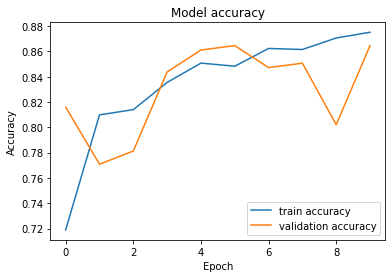

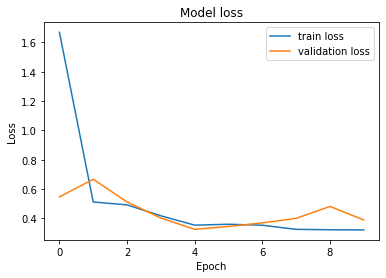

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(history)
plot_loss(history)

In [ ]:
y_pred = model.predict(X_val, verbose=1)
accuracy_score(np.argmax(y_val, axis=1),np.argmax(y_pred, axis=1))

10/10 [==============================] - 4s 318ms/step


0.8627450980392157

In [ ]:
y_pred = model.predict(X_test, verbose=1)
accuracy_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))

10/10 [==============================] - 2s 182ms/step


0.8859934853420195

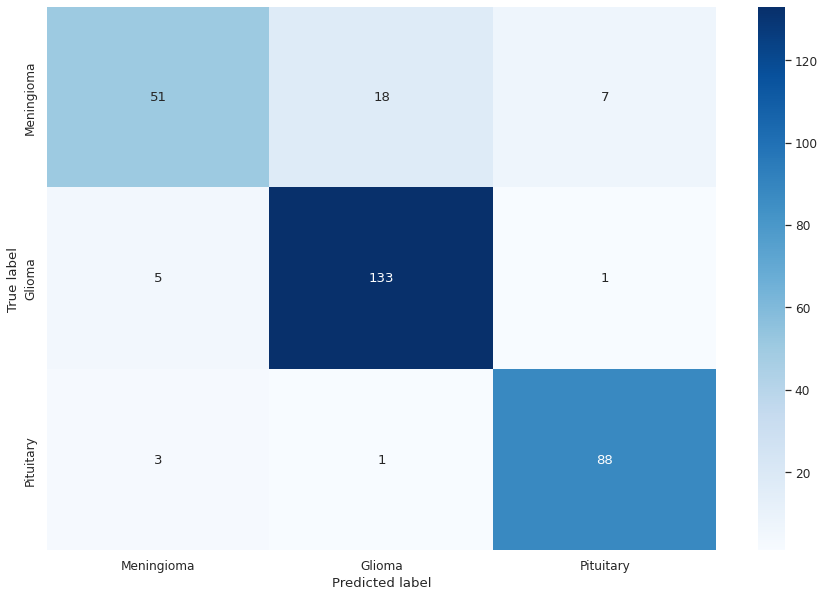

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def print_confusion_matrix(real,predicted):
    cmap="Blues"
    cm_plot_labels = ['Meningioma','Glioma','Pituitary']
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.1) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm, annot=True,fmt='g',cmap=cmap) # font size
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

print_confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))

In [ ]:
model.save('/content/drive/MyDrive/Collab/DMPA Project/model_resnetV50.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
